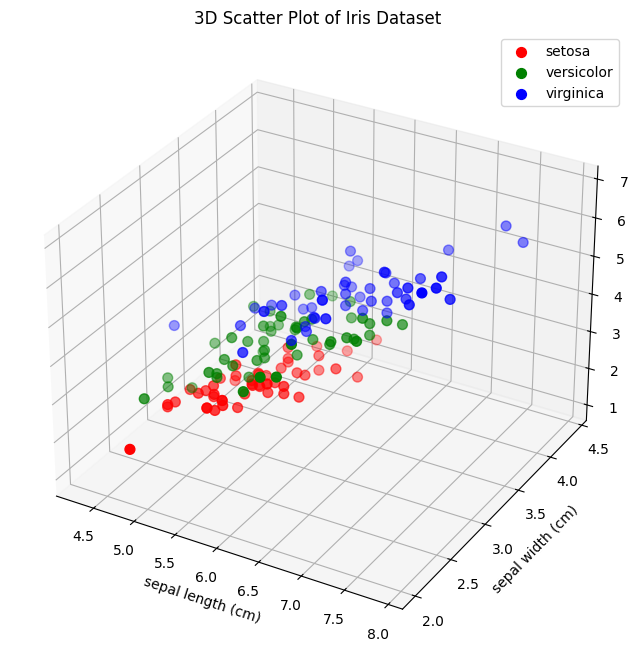

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

iris_df = pd.DataFrame(X, columns=iris.feature_names)
iris_df['target'] = y

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b']
for target, color in zip(range(len(iris.target_names)), colors):
    indices = iris_df['target'] == target
    ax.scatter(iris_df.loc[indices, iris.feature_names[0]],
               iris_df.loc[indices, iris.feature_names[1]],
               iris_df.loc[indices, iris.feature_names[2]],
               c=color,
               s=50,
               label=iris.target_names[target])

ax.set_xlabel(iris.feature_names[0])
ax.set_ylabel(iris.feature_names[1])
ax.set_zlabel(iris.feature_names[2])

plt.title('3D Scatter Plot of Iris Dataset')
plt.legend()
plt.show()


In [46]:

class myPCA:
    def __init__(self, n_components: int = 2, method: str = 'svd') -> None:
        '''
        The constructor of the PCA algorithm.
        
        :param n_components: int, default = 2
            The dimension to which the data will be reduced.
        :param method: str, default = 'svd'
            The method used by PCA to reduce the dimensionality of the data.
        '''
        self.__n_components = n_components
        if method in ['svd', 'eigen']:
            self.__method = method
        else:
            raise ValueError(f"'{method}' is not a method implemented in this model")

    def fit(self, X: np.array):
        '''
        The fitting method.
        
        :param X: np.array
            The data on which we want to fit the PCA
        '''
        if self.__method == 'svd':
            U, S, V = np.linalg.svd(X)
            self.__V = V[:self.__n_components, :]
        elif self.__method == 'eigen':
            corr_mat = np.corrcoef(X.T)
            # Getting the eigenvectors and eigenvalues
            self.eig_vals, self.eig_vecs = np.linalg.eig(corr_mat)
            # Sorting the list of tuples (eigenvalue, eigenvector)
            self.eig_pairs = [(np.abs(self.eig_vals[i]), self.eig_vecs[:, i]) for i in range(len(self.eig_vals))]
            self.eig_pairs.sort(key=lambda x: x[0], reverse=True)
            # Calculating the explained ratio
            total = sum(self.eig_vals)
            self.explained_variance_ratio = [(i / total) * 100 for i in sorted(self.eig_vals, reverse=True)]
            self.cumulative_variance_ratio = np.cumsum(self.explained_variance_ratio)
            # Creating the projection matrix
            self.matrix_w = np.hstack([self.eig_pairs[i][1].reshape(np.size(X, 1), 1) for i in range(self.__n_components)])
        return self

    def transform(self, X: np.array) -> np.array:
        '''
        The transform function.
        
        :param X: np.array
            The data that we must reduce.
        '''
        if self.__method == 'svd':
            return X.dot(self.__V.T)
        elif self.__method == 'eigen':
            return X.dot(self.matrix_w)

In [47]:
# preprocess data with Standard Scalar
from sklearn import preprocessing


scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

# Eigen alogirthm

In [48]:
mypca_eigen = myPCA(method='eigen')
mypca_eigen.fit(np.array(X))
X_eigen = mypca_eigen.transform(X)

# SVD algorithm

In [49]:
mypca_svd = myPCA(method='svd')
mypca_svd.fit(X)
X_svd = mypca_svd.transform(X)
X_svd

array([[-2.26470281, -0.4800266 ],
       [-2.08096115,  0.67413356],
       [-2.36422905,  0.34190802],
       [-2.29938422,  0.59739451],
       [-2.38984217, -0.64683538],
       [-2.07563095, -1.48917752],
       [-2.44402884, -0.0476442 ],
       [-2.23284716, -0.22314807],
       [-2.33464048,  1.11532768],
       [-2.18432817,  0.46901356],
       [-2.1663101 , -1.04369065],
       [-2.32613087, -0.13307834],
       [-2.2184509 ,  0.72867617],
       [-2.6331007 ,  0.96150673],
       [-2.1987406 , -1.86005711],
       [-2.26221453, -2.68628449],
       [-2.2075877 , -1.48360936],
       [-2.19034951, -0.48883832],
       [-1.898572  , -1.40501879],
       [-2.34336905, -1.12784938],
       [-1.914323  , -0.40885571],
       [-2.20701284, -0.92412143],
       [-2.7743447 , -0.45834367],
       [-1.81866953, -0.08555853],
       [-2.22716331, -0.13725446],
       [-1.95184633,  0.62561859],
       [-2.05115137, -0.24216355],
       [-2.16857717, -0.52714953],
       [-2.13956345,


# SKlearn algorithm

In [50]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
X_skl = pca.transform(X)
X_skl

array([[-2.26470281,  0.4800266 ],
       [-2.08096115, -0.67413356],
       [-2.36422905, -0.34190802],
       [-2.29938422, -0.59739451],
       [-2.38984217,  0.64683538],
       [-2.07563095,  1.48917752],
       [-2.44402884,  0.0476442 ],
       [-2.23284716,  0.22314807],
       [-2.33464048, -1.11532768],
       [-2.18432817, -0.46901356],
       [-2.1663101 ,  1.04369065],
       [-2.32613087,  0.13307834],
       [-2.2184509 , -0.72867617],
       [-2.6331007 , -0.96150673],
       [-2.1987406 ,  1.86005711],
       [-2.26221453,  2.68628449],
       [-2.2075877 ,  1.48360936],
       [-2.19034951,  0.48883832],
       [-1.898572  ,  1.40501879],
       [-2.34336905,  1.12784938],
       [-1.914323  ,  0.40885571],
       [-2.20701284,  0.92412143],
       [-2.7743447 ,  0.45834367],
       [-1.81866953,  0.08555853],
       [-2.22716331,  0.13725446],
       [-1.95184633, -0.62561859],
       [-2.05115137,  0.24216355],
       [-2.16857717,  0.52714953],
       [-2.13956345,

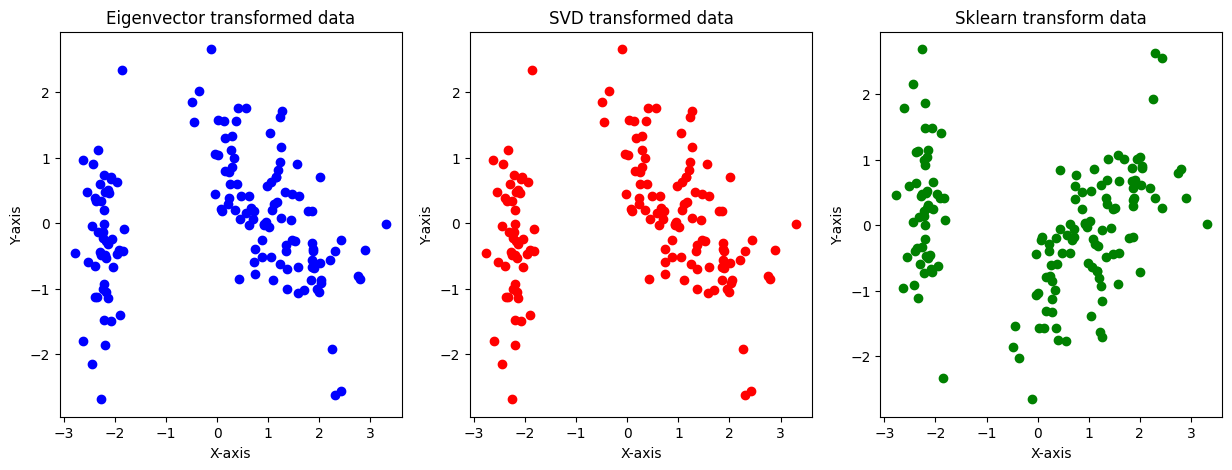

In [55]:
# Creating the plot
# Plotting the first scatter plot
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_eigen[:, 0], X_eigen[:, 1], color='blue')
plt.title('Eigenvector transformed data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Plotting the second scatter plot
plt.subplot(1, 3, 2)
plt.scatter(X_svd[:, 0], X_svd[:, 1], color='red')
plt.title('SVD transformed data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Plotting the third scatter plot
plt.subplot(1, 3, 3)
plt.scatter(X_skl[:, 0], X_skl[:, 1],  color='green')
plt.title('Sklearn transform data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Display all plots
plt.show()

# Conclusion